<a href="https://colab.research.google.com/github/aarchit22/alpha_matting_surface_normal/blob/main/summer_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi


Wed May 22 12:07:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
#trimap generation

%%writefile deep_script.py
import os
import argparse
import torch
import numpy as np
from torchvision import transforms
import cv2

IMG_EXT = ('.png', '.jpg', '.jpeg', '.JPG', '.JPEG')

CLASS_MAP = {"background": 0, "aeroplane": 1, "bicycle": 2, "bird": 3, "boat": 4, "bottle": 5, "bus": 6, "car": 7,
             "cat": 8, "chair": 9, "cow": 10, "diningtable": 11, "dog": 12, "horse": 13, "motorbike": 14, "person": 15,
             "potted plant": 16, "sheep": 17, "sofa": 18, "train": 19, "tv/monitor": 20}


def trimap(probs, size, conf_threshold):
    """
    This function creates a trimap based on simple dilation algorithm
    Inputs [3]: an image with probabilities of each pixel being the foreground, size of dilation kernel,
    foreground confidence threshold
    Output    : a trimap
    """
    mask = (probs > 0.05).astype(np.uint8) * 255

    pixels = 2 * size + 1
    kernel = np.ones((pixels, pixels), np.uint8)

    dilation = cv2.dilate(mask, kernel, iterations=1)

    remake = np.zeros_like(mask)
    remake[dilation == 255] = 127  # Set every pixel within dilated region as probably foreground.
    remake[probs > conf_threshold] = 255  # Set every pixel with large enough probability as definitely foreground.

    return remake


def parse_args():
    parser = argparse.ArgumentParser(description="Deeplab Segmentation")
    parser.add_argument(
        "-i",
        "--input_dir",
        type=str,
        required=True,
        help="Directory to save the output results. (required)",
    )
    parser.add_argument(
        "--target_class",
        type=str,
        default='person',
        choices=CLASS_MAP.keys(),
        help="Type of the foreground object.",
    )
    parser.add_argument(
        "--show",
        action='store_true',
        help="Use to show results.",
    )
    parser.add_argument(
        "--conf_threshold",
        type=float,
        default='0.95',
        help="Confidence threshold for the foreground object. "
             "You can play with it to get better looking trimaps.",
    )

    args = parser.parse_args()
    return args


def main(input_dir, target_class, show, conf_threshold):
    model = torch.hub.load('pytorch/vision:v0.6.0', 'deeplabv3_resnet101', pretrained=True)
    model.eval()

    trimaps_path = os.path.join(input_dir, "trimaps")
    os.makedirs(trimaps_path, exist_ok=True)

    images_list = os.listdir(input_dir)
    for filename in images_list:
        if not filename.endswith(IMG_EXT):
            continue
        input_image = cv2.imread(os.path.join(input_dir, filename))
        original_image = input_image.copy()

        input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

        preprocess = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        input_tensor = preprocess(input_image)
        input_batch = input_tensor.unsqueeze(0)  # create a mini-batch as expected by the model

        with torch.no_grad():
            output = model(input_batch)['out'][0]
            output = torch.softmax(output, 0)

        output_cat = output[CLASS_MAP[target_class], ...].numpy()

        trimap_image = trimap(output_cat, 7, conf_threshold)
        trimap_filename ='trimapping.png'
        cv2.imwrite(os.path.join(trimaps_path, trimap_filename), trimap_image)

        # Optionally, save the resulting images
        # cv2.imwrite(os.path.join(output_dir, filename), output_cat)
        # cv2.imwrite(os.path.join(output_dir, trimap_filename), trimap_image)


if __name__ == "__main__":
    args = parse_args()
    main(args.input_dir, args.target_class, args.show, args.conf_threshold)


Overwriting deep_script.py


In [8]:
# passing input RGB image for trimap

input_dir = '/content/drive/MyDrive/bam'
target_class = 'person'
show = '--show'  # Set to '' if you do not want to show the results
conf_threshold = 0.95

!python deep_script.py -i {input_dir} --target_class {target_class} {show} --conf_threshold {conf_threshold}


Downloading: "https://github.com/pytorch/vision/zipball/v0.6.0" to /root/.cache/torch/hub/v0.6.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100% 233M/233M [00:01<00:00, 175MB/s]


In [ ]:
!git clone https://github.com/pymatting/pymatting

Cloning into 'pymatting'...
remote: Enumerating objects: 1421, done.
remote: Counting objects: 100% (414/414), done.
remote: Compressing objects: 100% (200/200), done.
remote: Total 1421 (delta 245), reused 240 (delta 214), pack-reused 1007
Receiving objects: 100% (1421/1421), 7.33 MiB | 17.17 MiB/s, done.
Resolving deltas: 100% (849/849), done.


In [11]:
pip install pymatting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.3 MB/s eta 0:00:00


In [13]:
from pymatting import *
from pymatting import load_image

In [ ]:
import cv2

In [14]:
image = load_image("/content/drive/MyDrive/bam/subject.jpg", "RGB", 1.0, "box")

trimap = load_image("/content/drive/MyDrive/bam/trimaps/trimapping.png", "GRAY", 1.0, "nearest")

In [15]:
alpha = estimate_alpha_cf(image, trimap)

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [16]:
import matplotlib.pyplot as plt

(-0.5, 505.5, 696.5, -0.5)

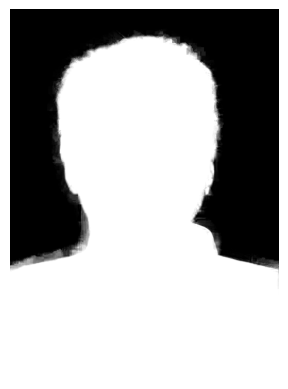

In [17]:
plt.imshow(alpha,cmap='gray')
plt.axis('off')